In [ ]:
# Welcome to Google Colab. The first thing you should do is click Copy To Drive on the bar above.
# Then, in the copied filed, click "Copy of Part1.ipynb" above.
# Rename this to Part1.ipynb.

In [ ]:
# To run a cell, click the run button on the left side. Alternatively, you can use Shift + Enter

In [ ]:
# YOU ONLY NEED TO RUN THIS CELL; NO NEED TO EDIT

# The next thing you must do is mount your drive using the code below.
# You will be told to go to a URL. Then, click your Google Account (use your Princeton Account)
# Click Sign In, copy the code presented, and then paste it in the prompt below this cell.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# YOU ONLY NEED TO RUN THIS CELL; NO NEED TO EDIT

# This is to change your directory to the current path.
# If you followed the instructions above, then you should be able to run this cell without errors.
# Otherwise, modify the path accordingly.
FOLDERNAME = "Colab Notebooks/"
assert FOLDERNAME is not None, "[!] Enter the foldername."
%cd drive/My\ Drive
%cd $FOLDERNAME
%ls

# At this point, you can read/write to local files in your current Google Drive directory.w

[Errno 2] No such file or directory: 'drive/My Drive'
/content/drive/My Drive/Colab Notebooks
[Errno 2] No such file or directory: 'Colab Notebooks/'
/content/drive/My Drive/Colab Notebooks
gmm.joblib                  Part1Starter.ipynb      Part2StarterJava.ipynb
kmeans.joblib               Part1StarterJava.ipynb  svm_model.joblib
Part1ExampleSubmission.txt  Part2Solution.ipynb     YeastPart1.txt
Part1Solutions.ipynb        Part2Starter.ipynb      YeastPart2.txt


In [ ]:
# YOU ONLY NEED TO RUN THIS CELL; NO NEED TO EDIT

# This function can be used to write every element in a list to a file (one element per line)
# You may find this useful to generate the output text file
def writeFile(filename, datalist):
  file = open(filename, "w")
  for d in datalist:
    file.write(f"{d}\n")
  file.close()

# Example
# For example, to save the data in guess_list to a text file in your local directory
# titled YeastPart1.txt, use the command below.
# writeFile("YeastPart1.txt", guess_list)

In [ ]:
# YOU ONLY NEED TO RUN THIS CELL; NO NEED TO EDIT

from pandas import *
import numpy as np
from sklearn.cluster import *
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from itertools import permutations
from joblib import dump, load
import matplotlib
import matplotlib.pyplot as plt

# This is to download Sally's dataset
!gdown --id 1BFVQcoV6nxTA_WDKE6tyXIpqoISLd6AX
df = read_csv("YeastTrainData.csv")

Downloading...
From: https://drive.google.com/uc?id=1BFVQcoV6nxTA_WDKE6tyXIpqoISLd6AX
To: /content/drive/My Drive/Colab Notebooks/YeastTrainData.csv
100% 57.3k/57.3k [00:00<00:00, 7.81MB/s]


In [ ]:
# Here is your dataset. You'll have to add your own code below (maybe consider adding new cells too). Have fun!
df

,Characteristic 1,Characteristic 2,Characteristic 3,Characteristic 4,Characteristic 5
0,1.211388,1.947021,-0.214540,-0.468657,0.053297
1,1.704126,2.436741,0.072167,0.506170,0.467671
2,2.157884,3.737526,0.578618,-0.229936,0.466264
3,0.659123,0.662741,0.310194,2.879255,1.188815
4,0.844030,2.918248,0.040624,-0.954727,-0.221208
...,...,...,...,...,...
635,-0.095900,-1.244922,1.514027,0.065038,2.526068
636,1.991669,3.664962,0.498174,0.273879,0.827710
637,1.112111,0.755396,3.429341,1.836416,3.769560
638,2.704005,4.352617,0.703393,0.327618,0.563296


In [ ]:
# convert from pandas dataframe to numpy array
X = df.to_numpy()

In [ ]:
# We'll perform some Principal Component Analysis (PCA). PCA is a method of changing the bases of a
# dataset so that each axis is uncorrelated with the other ones. In 2d, think of changing from x,y to
# another set of axes. Then, for visualization purposes, we project the points down to the first two axes,
# which are the most significant axes.
pca = PCA(n_components=2)
pca.fit(X)
X_2d = pca.transform(X)

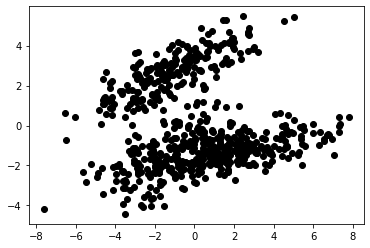

In [ ]:
# Hmm our data looks quite interesting!
plt.scatter(X_2d[:,0], X_2d[:,1], color='black');

In [ ]:
# Let's try applying K means
kmeans = KMeans(n_clusters=3, n_init=50, random_state=0).fit(X)
y_guesskm = kmeans.predict(X)

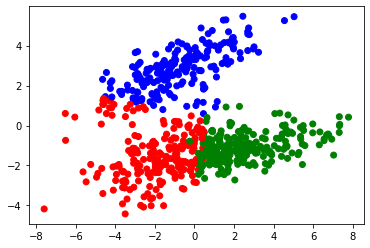

In [ ]:
# K means does a decent job of separating the data, but the green and red seem to be a bit incorrectly mixed.
colors = ['red','green','blue']
plt.scatter(X_2d[:,0], X_2d[:,1], c=y_guesskm, cmap=matplotlib.colors.ListedColormap(colors))

In [ ]:
# Manually implementing K-means wasn't required, but it's certainly allowed! Here is how you could do it.

####################################################################################################
# This function takes in data points and centroids, and returns the Euclidean distance between them
# Input:
# X (array of points), C (centroids)
# Returns:
# sq_dists[i,j] is the Euclidean distance between X[i] and W[i]
# min_dists returns the minimum distance between each point and the closest centroid
# assoc returns the centroid that is closest to each point
####################################################################################################
def differenceSquared(X, C):
  # Note that looping through and calculating Euclidean distances is slow.
  # Instead we will use numpy operations (which are coded in C++)
  # Key is to realize that (X[i] - C[j])^2 = X[i]^2 + C[j]^2 - 2*(X[i]^T)C[j]

  # Calculates the norm of X and C
  xn = np.linalg.norm(X, axis = 1)**2
  cn = np.linalg.norm(C, axis = 1)**2

  xn = np.expand_dims(xn, axis=1)
  cn = np.expand_dims(cn, axis=1)
    
  # Using the formula above to calculate distance between each point and each centroid
  x_repeat = np.tile(xn, (1,C.shape[0]))
  c_repeat = np.tile(cn.T, (X.shape[0],1))
  sq_dists = x_repeat + c_repeat - 2*(X @ C.T)

  min_dists = np.min(sq_dists, axis = 1)
  assoc = np.argmin(sq_dists, axis = 1)
  return sq_dists, min_dists, assoc

####################################################################################################
# This function takes in data points, number of centroids, and the associated centroid to each point
# It returns new centroids calculated by averaging all points that are associated with the same centroid.
# Input:
# X (array of points), k (number of centroids), assoc(associated centroids) 
# Returns:
# C (numpy array of new centroid points)
####################################################################################################
def update_centroids(X, num, assoc):
  C = np.zeros((num, X.shape[1]))
  # for each centroid
  for i in range(num):
    # gets the elements associated with this centroid and stores into mask
    mask = np.nonzero(assoc == i)[0]
    if mask.shape[0] != 0:
      # update centroids as long as there are > 0 data points associated with it
      C[i] = np.mean(X[mask], axis = 0)
  return C

####################################################################################################
# This function runs the K-means clustering algorithm.
# Input:
# X (numpy array of data points), num (number of centroids), max_epochs (number of epochs to run)
# Returns:
# C (numpy array of new centroid points), and loss (average distance to centroid among all points every iteration)
####################################################################################################
def kMeans(X, num, max_epochs=100):
  # Randomly initialize num centroids
  n = X.shape[0]
  indices = np.random.permutation(n)[:num]
  C = X[indices]

  # initialize the loss list
  loss = []

  # run for max_epochs iterations
  for itr in range(max_epochs):
    _, dist, assoc = differenceSquared(X, C)
    avg_dist = dist.mean()
    loss.append(avg_dist)
    C = update_centroids(X, num, assoc)

  # return centroids and loss
  return C, loss

####################################################################################################
# This function runs the K-means clustering algorithm num_runs times, and takes the one with the
# minimum total distance. K-means is dependent on the initialization of the centroids, so running
# multiple times can remove some of the variance in the results.
# Input:
# X (numpy array of data points), num_centroids (number of centroids), num_runs (number of runs)
# Returns:
# C (numpy array of new centroid points), and loss (average distance to centroid among all points every iteration)
####################################################################################################
def multiple_runs(X, num_centroids, num_runs):
  best_centroids = np.zeros((num_centroids, X.shape[1]))
  correspondence = np.zeros((3, X.shape[1]))
  best_diff = -1
  for t in range(10):
    centroids, _ = kMeans(X, num_centroids)
    dists, min_dists, min_indices = differenceSquared(X, centroids)
    dist_sum = np.sum(min_dists)

    if best_diff < 0 or dist_sum < best_diff:
      best_diff = dist_sum
      best_centroids = centroids

  return best_centroids

In [ ]:
manualcentroids = multiple_runs(X, 3, 20)
_, _, y_guesskmmanual = differenceSquared(X, manualcentroids)

In [ ]:
# Let's try using a more advanced technique such as a DB scan. This method clusters poitns together based on density.
# Note this method does NOT require us to pass in the number of clusters that we want. Instead, it will try to determine
# the number of clusters itself. Clusters that don't belong fall into outliers.
dbscan = DBSCAN(eps=0.99, min_samples=5).fit(X)
y_guessdb = dbscan.labels_

# For our purposes, we'll consider any cluster with label -1 or >= 3 to be an outlier
y_guessdb[y_guessdb < 0] = -1
y_guessdb[y_guessdb >= 3] = -1

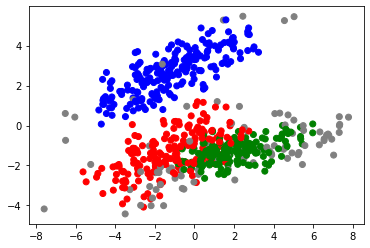

In [ ]:
# DB scan seems more effective! However, we do see a number of outliers (in gray).
colors = ['gray','blue','red','green',]
plt.scatter(X_2d[:,0], X_2d[:,1], c=y_guessdb, cmap=matplotlib.colors.ListedColormap(colors))

In [ ]:
# For this case, we'll just convert outliers to a random result between 0 and 2
y_guessdb[y_guessdb < 0] = np.random.randint(0, 3, size=np.count_nonzero(y_guessdb < 0))

In [ ]:
# Inspired by the fact that the mixtures look Gaussian, we will try a Gaussian Mixture Model
gmm = GaussianMixture(n_components=3, random_state=0).fit(X)
y_guessgmm = gmm.predict(X)

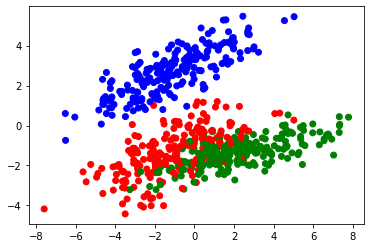

In [ ]:
# Wow, the separation looks really good!
colors = ['green','blue','red']
plt.scatter(X_2d[:,0], X_2d[:,1], c=y_guessgmm, cmap=matplotlib.colors.ListedColormap(colors))

In [ ]:
# Write out results (we choose the gmm model) to a text file
writeFile("YeastPart1.txt", y_guessgmm)

In [ ]:
# Let's try learning from our predicted labels
# One fairly robust supervised learning algorithm is the Support-vector machine (SVM).
# We could also use neural networks, but since there are only 600+ data points, using a neaural
# network could lead to overfitting.
svm_model = svm.SVC(kernel='rbf') # Radial Basis Function (RBF) kernel
svm_model.fit(X, y_guessgmm)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
# Save our models into our local file directory!!!
dump(kmeans, 'kmeans.joblib')
dump(gmm, 'gmm.joblib')
dump(svm_model, 'svm_model.joblib')

['svm_model.joblib']

In [ ]:
########################################################################################################################
# Note: Everything from this point onwards was not possible during the actual contest. From this point onwards, we will
# be evaluating how well the model actually did by looking at the actual labels. The actual labels were not provided
# during the contest.
########################################################################################################################

In [ ]:
# You were not provided with this during the contest
# However, in the official solution, we will load it up and check it out
!gdown --id 1Q1eah2zVpk5I0iEWjhofiZ7CKBYO88YD
true_labels = read_csv("YeastTrainLabels.csv")
true_labels = true_labels.to_numpy()
y = true_labels[:, 1].flatten()

Downloading...
From: https://drive.google.com/uc?id=1Q1eah2zVpk5I0iEWjhofiZ7CKBYO88YD
To: /content/drive/My Drive/Colab Notebooks/YeastTrainLabels.csv
100% 4.38k/4.38k [00:00<00:00, 3.87MB/s]


In [ ]:
# This function is what we used to calculate your accuracy
def predict_acc(y_guess, y_truth):
  perm_list = list(permutations([0,1,2]))
  best_acc = 0
  for perm in perm_list:
    cur = 0
    for i, p in enumerate(perm):
      cur += np.sum((y_guess==p) & (y_truth==i))
    best_acc = max(best_acc, cur/len(y_truth))
  return best_acc

In [ ]:
# Let's see how well our models actually did!
print(f"K-means Clustering accuracy (sklearn): {predict_acc(y_guesskm, y)}")
print(f"K-means Clustering accuracy (manual): {predict_acc(y_guesskmmanual, y)}")
print(f"DB Scan accuracy: {predict_acc(y_guessdb, y)}")
print(f"Gaussian Mixture Model accuracy: {predict_acc(y_guessgmm, y)}")

K-means Clustering accuracy (sklearn): 0.8453125
K-means Clustering accuracy (manual): 0.8390625
DB Scan accuracy: 0.9015625
Gaussian Mixture Model accuracy: 0.996875
